# Custom models



In this document we develop custom sklearn estimators. The main outcome is a hybrid machine learning model which evaluates a linear regression if a certain condition is met, and evaluates another linear regression, or gives a trivial output, if the condition is not met.  

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_validate

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression

from matplotlib_venn import venn2
from tqdm import tqdm

from imblearn.over_sampling import SMOTENC




In [9]:
import pickle

In [10]:
import src.features as features
import src.model_selection as model_selection 
import src.functions as functions
import src.datasets as datasets 

## Developing a custom sklearn estimator

We follow the guides at the following links 
- https://sklearn-template.readthedocs.io/en/latest/user_guide.html
- https://scikit-learn.org/dev/developers/develop.html


In [11]:
from sklearn.base import ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.utils.validation import check_is_fitted

### The model "OffLogistic" definition

In [12]:


class OffLogistic(ClassifierMixin):
    def __init__(self, random_state = 42, features = []):
        # parameters
        self.random_state = random_state

        # internal variable, exposed to user
        self.model_ = LogisticRegression(random_state=random_state)
        self.features_ = features

    def fit(self, X, y):

        # expect feature names for X
        # expect variables offtrt and time
        

        mask_on = X['offtrt'] < 0
        if "time" in X.columns:
            mask_time = X['time'] <= 707
        elif "time_censored" in X.columns:
            mask_time = X['time_censored'] >= -0.33836866


        if len(self.features_) > 0:
            X_fit = X.copy()[self.features_]
        else:
            X_fit = X.copy()

        #X_on_time = X[mask_on & mask_time]
        X_other = X_fit[~(mask_on & mask_time)]
        y_other = y[~(mask_on & mask_time)]

        self.model_.fit(X_other,y_other)

        return self
    
    def predict(self,X) :

        
        if len(self.features_) > 0:
            X_fit = X.copy()[self.features_]
        else:
            X_fit = X.copy()
        

        mask_on = X_fit['offtrt'] < 0
        if "time" in X.columns:
            mask_time = X_fit['time'] <= 707
        elif "time_censored" in X.columns:
            mask_time = X_fit['time_censored'] >= -0.33836866

        X_on_time = X_fit[mask_on & mask_time]
        X_other = X_fit[~(mask_on & mask_time)]

        y_pred = pd.Series(index=X.index)

        y_pred.loc[mask_on & mask_time] = 1
        y_pred.loc[~(mask_on & mask_time)] = self.model_.predict(X_other)
        
        return y_pred 
    

    def predict_proba(self,X) :

        if len(self.features_) > 0:
            X_fit = X.copy()[self.features_]
        



        mask_on = X_fit['offtrt'] < 0
        if "time" in X_fit.columns:
            mask_time = X_fit['time'] <= 707
        elif "time_censored" in X.columns:
            mask_time = X_fit['time_censored'] >= -0.33836866

        X_on_time = X_fit[mask_on & mask_time]
        X_other = X_fit[~(mask_on & mask_time)]

        y_proba = pd.Series(index=X.index)

        y_proba.loc[mask_on & mask_time] = (0,1)
        y_proba.loc[~(mask_on & mask_time)] = self.model_.predict_proba(X_other)
        
        return y_proba


    def get_params(self, deep=True):
        """
        Return the parameters of the classifier as a dictionary.
        The get_params function takes no arguments and returns a dict of the __init__ parameters of the estimator, together with their values.
        """
        return {"random_state": self.random_state, "features": self.features_}

    def set_params(self, **params):
        """
        Set the parameters of the classifier.
        """
        for key, value in params.items():
            setattr(self, key, value)
        return self




    

### The model "OffLogistic2"

In [13]:

class OffLogistic2(ClassifierMixin):
    def __init__(self, 
                random_state = 42, 
                features_on = ['z30', 'cd420', 'time730'], 
                features_off = ['age', 'drugs', 'hemo', 'cd820', 'preanti', 'race', 'cd420', 'time730', 'z30', 'time_censored']):
        # parameters
        self.random_state = random_state
        self.features_off = features_off
        self.features_on = features_on

        # internal variables, exposed to user
        self.model_on_ = LogisticRegression(random_state=random_state)
        self.model_off_ = LogisticRegression(random_state=random_state)
    
    def mask_on_time1(self,X,y):      
        mask_time1 = X['time_censored']>=-0.33836866
        mask_on = X['offtrt']<0

        X_on = X[ mask_on & mask_time1]
        y_on = y[ mask_on & mask_time1]

        X_on_copy = X_on.copy() #.drop(columns = ['offtrt'])

        return X_on_copy, y_on.copy(), mask_on & mask_time1

    def mask_on_time2(self,X,y):      
        mask_time2 = X['time_censored']<-0.33836866
        mask_on = X['offtrt']<0

        X_on = X[ mask_on & mask_time2]
        y_on = y[ mask_on & mask_time2]
        
        X_on = X_on[self.features_on]


        X_on_copy = X_on.copy() #.drop(columns = ['offtrt'])

        return X_on_copy, y_on.copy(), mask_on & mask_time2

    def mask_off(self,X,y):
        mask_off = X['offtrt']>0

        X_off = X[ mask_off]
        y_off = y[ mask_off]

        X_off = X_off[self.features_off]

        X_off_copy = X_off.copy() #.drop(columns = ['offtrt'])


        return X_off_copy, y_off, mask_off


    def fit(self, X, y):

        # expect feature names for X
        # expect variables offtrt and time_censored
        
        X_on_time1, y_on_time1, mask_on_time1 = self.mask_on_time1(X,y)
        X_on_time2, y_on_time2, mask_on_time2 = self.mask_on_time2(X,y)
        X_off, y_off, mask_off = self.mask_off(X,y)
        
        self.model_on_.fit(X_on_time2,y_on_time2)
        self.model_off_.fit(X_off,y_off)

        return self
    
    def predict(self,X) :

        
        X_on_time1, y_on_time1, mask_on_time1 = self.mask_on_time1(X,X)
        X_on_time2, y_on_time2, mask_on_time2 = self.mask_on_time2(X,X)
        X_off, y_off, mask_off = self.mask_off(X,X)
        
        y_pred = pd.Series(index=X.index)

        y_pred.loc[mask_on_time1] = 1
        y_pred.loc[mask_on_time2] = self.model_on_.predict(X_on_time2)
        y_pred.loc[mask_off] = self.model_off_.predict(X_off)
        
        return y_pred 
    

    def predict_proba(self,X) :

        
        X_on_time1, y_on_time1, mask_on_time1 = self.mask_on_time1(X,X)
        X_on_time2, y_on_time2, mask_on_time2 = self.mask_on_time2(X,X)
        X_off, y_off, mask_off = self.mask_off(X,X)
        

        y_proba = pd.Series(index=X.index)

        y_proba.loc[mask_on_time1] = [[0, 1]] * mask_on_time1.sum()
        y_proba.loc[mask_on_time2] = self.model_on_.predict_proba(X_on_time2)
        y_proba.loc[mask_off] = self.model_off_.predict_proba(X_off)
        
        return y_proba


    def get_params(self, deep=True):
        """
        Return the parameters of the classifier as a dictionary.
        """
        return {"random_state": self.random_state, "features_on": self.features_on, "features_off": self.features_off}

    def set_params(self, **params):
        """
        Set the parameters of the classifier.
        """
        for key, value in params.items():
            setattr(self, key, value)
        return self




    

### The model Offlogistic3 with scaler and oversampler

In [14]:
from imblearn.over_sampling import SMOTENC


In [39]:

class OffLogistic3(ClassifierMixin):
    def __init__(self, 
                random_state = 42, 
                features_on = ['z30', 'cd420', 'time730'], 
                features_off = ['age', 'drugs', 'hemo', 'cd820', 'preanti', 'race', 'cd420', 'time730', 'z30', 'time_censored']):
        # parameters
        self.random_state = random_state
        self.features_off = features_off
        self.features_on = features_on

        # internal variables, exposed to user
        self.scaler_on_ = StandardScaler()
        self.scaler_off_ = StandardScaler()
        self.cat_features_on = [c for c in features_on if c in self.all_cat_features()]
        self.cat_features_off = [c for c in features_off if c in self.all_cat_features()]
        self.smote_on_ = SMOTENC(categorical_features=self.cat_features_on, sampling_strategy=1.0, random_state=42)
        self.smote_off_ = SMOTENC(categorical_features=self.cat_features_off, sampling_strategy=1.0, random_state=42)
        self.model_on_ = LogisticRegression(random_state=random_state)
        self.model_off_ = LogisticRegression(random_state=random_state)
    
    def all_cat_features(self):
        
        return  ['hemo', 'homo', 'drugs', 'karnof',
                'oprior', 'z30', 'race', 'gender',
                'str2', 'strat', 'symptom', 'offtrt',
                'trt0', 'trt1', 'trt2']

    def mask_on_time1(self,X,y):      
        #mask_time1 = X['time_censored']>=-0.33836866
        mask_time1 = X['time_censored']>=23
        mask_on = X['offtrt']==0

        X_on = X[ mask_on & mask_time1]
        y_on = y[ mask_on & mask_time1]

        X_on_copy = X_on.copy() #.drop(columns = ['offtrt'])

        return X_on_copy, y_on.copy(), mask_on & mask_time1

    def mask_on_time2(self,X,y):      
        mask_time2 = X['time_censored']<23
        mask_on = X['offtrt']==0

        X_on = X[ mask_on & mask_time2]
        y_on = y[ mask_on & mask_time2]
        
        X_on = X_on[self.features_on]


        X_on_copy = X_on.copy() #.drop(columns = ['offtrt'])

        return X_on_copy, y_on.copy(), mask_on & mask_time2

    def mask_off(self,X,y):
        mask_off = X['offtrt']==1

        X_off = X[ mask_off]
        y_off = y[ mask_off]

        X_off = X_off[self.features_off]

        X_off_copy = X_off.copy() #.drop(columns = ['offtrt'])


        return X_off_copy, y_off, mask_off


    def fit(self, X, y):

        # expect feature names for X
        # expect variables offtrt and time_censored
        # requires unscaled data
        
        X_on_time1, y_on_time1, mask_on_time1 = self.mask_on_time1(X,y)
        X_on_time2, y_on_time2, mask_on_time2 = self.mask_on_time2(X,y)
        X_off, y_off, mask_off = self.mask_off(X,y)

        self.scaler_on_.fit(X_on_time2)
        self.scaler_off_.fit(X_off)

        X_on_scaled = pd.DataFrame( self.scaler_on_.transform(X_on_time2), columns = self.features_on)
        X_off_scaled = pd.DataFrame( self.scaler_off_.transform(X_off), columns = self.features_off)

        X_on_smote, y_on_smote = self.smote_on_.fit_resample(X_on_scaled,y_on_time2)
        X_off_smote, y_off_smote = self.smote_on_.fit_resample(X_off_scaled,y_off)
        
        self.model_on_.fit(X_on_smote,y_on_smote)
        self.model_off_.fit(X_off_smote,y_off_smote)

        return self
    
    def predict(self,X) :

        
        _,          _,  mask_on_time1 = self.mask_on_time1(X,X)
        X_on_time2, _,  mask_on_time2 = self.mask_on_time2(X,X)
        X_off,      _,  mask_off = self.mask_off(X,X)
        
        y_pred = pd.Series(index=X.index)

        X_on_test_scaled = pd.DataFrame(self.scaler_on_.transform(X_on_time2), columns = self.features_on )
        X_off_test_scaled = pd.DataFrame(self.scaler_off_.transform(X_off),columns = self.features_off )

        y_pred.loc[mask_on_time1] = 1
        y_pred.loc[mask_on_time2] = self.model_on_.predict(X_on_test_scaled)
        y_pred.loc[mask_off] = self.model_off_.predict(X_off_test_scaled)
        
        return y_pred 
    

    def predict_proba(self,X) :

        _,          _,  mask_on_time1 = self.mask_on_time1(X,X)
        X_on_time2, _,  mask_on_time2 = self.mask_on_time2(X,X)
        X_off,      _,  mask_off = self.mask_off(X,X)
        
        X_on_test_scaled = pd.DataFrame(self.scaler_on_.transform(X_on_time2), columns = self.features_on )
        X_off_test_scaled = pd.DataFrame(self.scaler_off_.transform(X_off),columns = self.features_off )

        y_proba = pd.Series(index=X.index)

        y_proba.loc[mask_on_time1] = [[0, 1]] * mask_on_time1.sum()
        y_proba.loc[mask_on_time2] = self.model_on_.predict_proba(X_on_test_scaled)
        y_proba.loc[mask_off] = self.model_off_.predict_proba(X_off_test_scaled)
        
        return y_proba


    def get_params(self, deep=True):
        """
        Return the parameters of the classifier as a dictionary.
        """
        return {"random_state": self.random_state, "features_on": self.features_on, "features_off": self.features_off}

    def set_params(self, **params):
        """
        Set the parameters of the classifier.
        """
        for key, value in params.items():
            setattr(self, key, value)

        self.cat_features_on = [c for c in self.features_on if c in self.all_cat_features()]
        self.cat_features_off = [c for c in self.features_off if c in self.all_cat_features()]
        self.smote_on_ = SMOTENC(categorical_features=self.cat_features_on, sampling_strategy=1.0, random_state=42)
        self.smote_off_ = SMOTENC(categorical_features=self.cat_features_off, sampling_strategy=1.0, random_state=42)
        self.model_on_ = LogisticRegression(random_state=self.random_state)
        self.model_off_ = LogisticRegression(random_state=self.random_state)
    
        return self




    

## Load data

In [16]:
data = datasets.data_original()

In [17]:
data = features.engineer(data)

### Train test split (unprocessed)

In [18]:
X_, y_ = data.drop('infected', axis=1), data['infected']
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size = 0.2, random_state=42, stratify = y_)


### Oversampling train data 

In [19]:
# identify categorical features 
# The dataset does not have categorical features with more than 4 categories
cat_features = [c for c in X_train_.columns if X_train_[c].nunique() < 5]

In [20]:
smote_nc = SMOTENC(categorical_features=cat_features, sampling_strategy=1.0, random_state=42)
X_oversampled, y_oversampled = smote_nc.fit_resample(X_train_, y_train_) 

### Scaling the data 

In [21]:
scaler = StandardScaler()

scaler.fit(X_train_)

X_train_scaled_oversampled = scaler.transform(X_oversampled)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_), columns = X_train_.columns)
X_train_scaled = pd.DataFrame(scaler.transform(X_train_), columns = X_train_.columns)

### Data ready for Machine Learning

In [22]:
X_train = pd.DataFrame(X_train_scaled_oversampled,columns=X_.columns)
X_test = pd.DataFrame(X_test_scaled,columns=X_.columns)
y_train =y_oversampled 
y_test = y_test_ 

## Train test evaluation

### Load and train the models

In [40]:
model1 = OffLogistic()
model2 = OffLogistic2()
model3 = OffLogistic3()

In [104]:
model1.fit(X_train,y_train)
model2.fit(X_train,y_train)
model3.fit(X_train_,y_train_)

In [106]:
import pickle
""" last saved 17/01/2025
filenames = ['models/offlogistic1_smote.pkl', 'models/offlogistic2_smote.pkl', 'models/offlogistic3.pkl']
models = [model1,model2,model3]

for filename, model in zip(filenames,models):
    with open(filename,"wb") as file:
        pickle.dump(model,file)
"""


' last saved 17/01/2025\nfilenames = [\'models/offlogistic1_smote.pkl\', \'models/offlogistic2_smote.pkl\', \'models/offlogistic3.pkl\']\nmodels = [model1,model2,model3]\n\nfor filename, model in zip(filenames,models):\n    with open(filename,"wb") as file:\n        pickle.dump(model,file)\n'

### Test accuracy and recall

In [42]:
y_pred1 = model1.predict(X_test)
y_pred2 = model2.predict(X_test)
y_pred3 = model3.predict(X_test_)

In [45]:
print("OffLogistic test accuracy", accuracy_score(y_test,y_pred1))
print("OffLogistic2 test accuracy", accuracy_score(y_test,y_pred2))
print("OffLogistic3 test accuracy", accuracy_score(y_test,y_pred3))

OffLogistic test accuracy 0.8995327102803738
OffLogistic2 test accuracy 0.9112149532710281
OffLogistic3 test accuracy 0.8925233644859814


In [46]:
print("OffLogistic test recall", recall_score(y_test,y_pred1))
print("OffLogistic2 test recall", recall_score(y_test,y_pred2))
print("OffLogistic3 test recall", recall_score(y_test,y_pred3))

OffLogistic test recall 0.8076923076923077
OffLogistic2 test recall 0.8365384615384616
OffLogistic2 test recall 0.8557692307692307


## CV accuracy and recall

In [47]:

scaler = StandardScaler()

scaler.fit(X_train_)

StandardScaler()

### CV scoring with an ad hoc algorithm

In [48]:
from sklearn.base import clone

In [95]:
scaler = StandardScaler()
scaler.fit(X_train_)

def cv_accuracy_recall(Xtrain, ytrain, model, title= "modelname", verbose = False, n_splits = 5, scale = True):
    # Create the K-Fold cross-validator
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    if scale:
        #scaling
        Xtrain_scaled = pd.DataFrame(scaler.transform(Xtrain), columns = X_train_.columns)
        X_train_reindexed = Xtrain_scaled.copy()
    else:
        X_train_reindexed = Xtrain.copy()

    
    # prepare the data
    #X_train_reindexed = Xtrain_scaled.copy()
    X_train_reindexed.reset_index(inplace=True, drop = True)
    y_train_reindexed = ytrain.copy()
    y_train_reindexed.reset_index(drop=True, inplace=True)
    
    # initialize arrays to store the evaluations of each fold
    recall = []
    accuracy = []
    i = 0

    # the syntax to perform cv using cv.split(X,y) has been learned from
    # source https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html
    for train_fold_index, val_fold_index in cv.split(X_train_reindexed, y_train_reindexed):
        
        # Get the training data
        X_train_fold, y_train_fold = X_train_reindexed.iloc[train_fold_index], y_train_reindexed[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X_train_reindexed.iloc[val_fold_index], y_train_reindexed[val_fold_index]

        if verbose:
            print("fold number :", i)

        # create a untrained copy of the model with same hyperparameters (requires .get_params)
        model_cv = clone(model)
        
        # fit, evaluate and save the results
        model_cv.fit(X_train_fold, y_train_fold)
        y_pred  = model_cv.predict(X_val_fold)

        accuracy.append(accuracy_score(y_val_fold,y_pred))
        recall.append(recall_score(y_val_fold,y_pred))

        i+=1

    # organize the results in a dictionary
    cv_scores = {
        "model" : title,
        "accuracy" : sum(accuracy)/n_splits,
        "recall" : sum(recall)/n_splits
    }
    return cv_scores

### CV ad hoc with oversampling

In [57]:
from imblearn.over_sampling import SMOTENC


In [89]:
scaler = StandardScaler()
scaler.fit(X_train_)

def cv_accuracy_recall_oversampled(Xtrain, ytrain, model, title= "modelname", verbose = False, n_splits = 5):
    # Create the K-Fold cross-validator
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    cat_features = [c for c in Xtrain if Xtrain[c].nunique() < 5]
    smote_nc =  SMOTENC(categorical_features=cat_features, sampling_strategy=1.0, random_state=42)


    # prepare the data
    X_train_reindexed = Xtrain.copy()
    X_train_reindexed.reset_index(inplace=True, drop = True)
    y_train_reindexed = ytrain.copy()
    y_train_reindexed.reset_index(drop=True, inplace=True)
    
    # initialize arrays to store the evaluations of each fold
    recall = []
    accuracy = []
    i = 0

    # the syntax to perform cv using cv.split(X,y) has been learned from
    # source https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html
    for train_fold_index, val_fold_index in cv.split(X_train_reindexed, y_train_reindexed):
        
        # Get the training data
        X_train_fold, y_train_fold = X_train_reindexed.iloc[train_fold_index], y_train_reindexed[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X_train_reindexed.iloc[val_fold_index], y_train_reindexed[val_fold_index]
        # Oversample the train data
        X_train_oversampled, y_train_oversampled = smote_nc.fit_resample(X_train_fold,y_train_fold)
        
        # scaling
        Xtrain_oversampled_scaled = pd.DataFrame(scaler.transform(X_train_oversampled), columns = X_train_.columns)
        Xval_scaled = pd.DataFrame(scaler.transform(X_val_fold), columns = X_train_.columns)


        if verbose:
            print("fold number :", i)

        # create a untrained copy of the model with same hyperparameters (requires .get_params)
        model_cv = clone(model)
        
        # fit, evaluate and save the results
        model_cv.fit(Xtrain_oversampled_scaled, y_train_oversampled)
        y_pred  = model_cv.predict(Xval_scaled)

        accuracy.append(accuracy_score(y_val_fold,y_pred))
        recall.append(recall_score(y_val_fold, y_pred))

        i+=1

    # organize the results in a dictionary
    cv_scores = {
        "model" : title,
        "accuracy" : sum(accuracy)/n_splits,
        "recall" : sum(recall)/n_splits
    }
    return cv_scores #, accuracy, recall

#### CV accuracy recall results

In [90]:
cv_accuracy_recall(X_train_,y_train_,model1, "OffLogistic")

{'model': 'OffLogistic',
 'accuracy': 0.8871992907438665,
 'recall': np.float64(0.7218875502008032)}

In [91]:
cv_accuracy_recall(X_train_,y_train_,model2, "OffLogistic2")

{'model': 'OffLogistic2',
 'accuracy': 0.8942117197756296,
 'recall': np.float64(0.72429718875502)}

In [92]:
cv_accuracy_recall_oversampled(X_train_,y_train_,model1, "OffLogistic_smotenc")

{'model': 'OffLogistic_smotenc',
 'accuracy': 0.875503384311118,
 'recall': np.float64(0.8033849684452093)}

In [93]:
cv_accuracy_recall_oversampled(X_train_,y_train_,model2, "OffLogistic2_smotenc")

{'model': 'OffLogistic2_smotenc',
 'accuracy': 0.8813445177569775,
 'recall': np.float64(0.8464429145152037)}

In [96]:
cv_accuracy_recall(X_train_,y_train_,model3,"OffLogistic3", scale = False)

{'model': 'OffLogistic3',
 'accuracy': 0.8644025028557788,
 'recall': np.float64(0.884853700516351)}

### CV scoring with imnblearn pipelines - not yet working with custom model

the function cross_validation takes steps which turn the data into 2d arrays - our model requires named columns

#### Smote_NC wrapper for column names

In [79]:
from sklearn.base import BaseEstimator, TransformerMixin

# this class performs SMOTE_nc by keeping the columns names
class SMOTENCWrapper(BaseEstimator):
    def __init__(self, smote_nc, column_names):
        self.smote_nc = smote_nc
        self.column_names = column_names

    def fit(self, X, y):
        self.smote_nc.fit(X, y)
        return self

    def fit_resample(self, X, y=None):
        X_resampled, y_resampled = self.smote_nc.fit_resample(X,y)
        return pd.DataFrame(X_resampled, columns=self.column_names), y_resampled


In [59]:
from imblearn.over_sampling import SMOTENC


In [80]:
cat_features = [c for c in X_train_ if X_train_[c].nunique() < 5]
smote_nc =  SMOTENC(categorical_features=cat_features, sampling_strategy=1.0, random_state=42)
smote_wrapper = SMOTENCWrapper(smote_nc, column_names=X_train_.columns)

#### Imblearn pipeline

In [67]:
from imblearn.pipeline import Pipeline, make_pipeline

In [81]:
model = OffLogistic2()
imba_pipeline = make_pipeline(smote_wrapper, model)

In [74]:
from src.model_selection import cv_accuracy_recall

In [82]:

cv_accuracy_recall(X_train_scaled,y_train_, imba_pipeline, "OffLogistic2_imblearn")

{'accuracy': np.float64(nan),
 'recall': np.float64(nan),
 'model': 'OffLogistic2_imblearn'}

## RFE algorithm

### Load RFE features

In [97]:
import pickle

In [98]:
with open("models/rfe_features_off.pkl", "rb") as file:
    rfe_features_df = pickle.load(file)

results_rfe_kfold_cv = pd.DataFrame()
results_rfe_kfold_cv['features'] = rfe_features_df


In [99]:
rfe_features_df

k
1                                             [time730]
2                                      [cd420, time730]
3                                 [age, cd420, time730]
4                        [age, preanti, cd420, time730]
5                  [age, hemo, preanti, cd420, time730]
6            [age, hemo, preanti, race, cd420, time730]
7     [age, hemo, preanti, race, cd420, time730, tim...
8     [age, hemo, z30, preanti, race, cd420, time730...
9     [age, hemo, z30, preanti, race, str2, cd420, t...
10    [age, hemo, z30, preanti, race, str2, symptom,...
11    [age, hemo, z30, preanti, race, str2, strat, s...
12    [age, hemo, drugs, z30, preanti, race, str2, s...
13    [age, hemo, homo, drugs, z30, preanti, race, s...
14    [age, hemo, homo, drugs, z30, preanti, race, g...
15    [age, hemo, homo, drugs, z30, preanti, race, g...
16    [age, hemo, homo, drugs, oprior, z30, preanti,...
17    [age, hemo, homo, drugs, oprior, z30, preanti,...
18    [age, hemo, homo, drugs, oprior, z30, pr

In [100]:
old_rfe_features = set()
for k in range(len(results_rfe_kfold_cv['features'])):
    new_rfe_features = set(list(results_rfe_kfold_cv['features'])[k])
    new_feature = new_rfe_features - old_rfe_features
    old_rfe_features = new_rfe_features
    print(k, new_feature)


0 {'time730'}
1 {'cd420'}
2 {'age'}
3 {'preanti'}
4 {'hemo'}
5 {'race'}
6 {'time_censored'}
7 {'z30'}
8 {'str2'}
9 {'symptom'}
10 {'strat'}
11 {'drugs'}
12 {'homo'}
13 {'gender'}
14 {'cd80'}
15 {'oprior'}
16 {'trt0'}
17 {'trt2'}
18 {'karnof'}
19 {'cd820'}
20 {'trt1'}
21 {'cd40'}
22 {'wtkg'}


### Compare OffLogistic2 with LinearRegression

In [101]:
for rfe_features in results_rfe_kfold_cv['features']:
    #rfe_features = ['hemo', 'drugs', 'z30', 'race', 'gender', 'offtrt', 'cd420', 'time730', 'time_censored', 'cd80']

    model = OffLogistic2(features_off=rfe_features)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    rec = recall_score(y_test,y_pred)

    model = LogisticRegression(random_state = 42)
    X_rfe = X_train[rfe_features  + ['offtrt']]
    model.fit(X_rfe,y_train)
    y_pred = model.predict(X_test[rfe_features  + ['offtrt']])
    acc2 = accuracy_score(y_test,y_pred)
    rec2 = recall_score(y_test,y_pred)

    print(len(rfe_features), acc, rec , "compare", acc2, rec2)

1 0.8294392523364486 0.8461538461538461 compare 0.8177570093457944 0.8076923076923077
2 0.8574766355140186 0.8365384615384616 compare 0.8574766355140186 0.8557692307692307
3 0.866822429906542 0.8365384615384616 compare 0.852803738317757 0.8557692307692307
4 0.8761682242990654 0.8461538461538461 compare 0.8551401869158879 0.8461538461538461
5 0.8761682242990654 0.8365384615384616 compare 0.8574766355140186 0.8461538461538461
6 0.8901869158878505 0.8269230769230769 compare 0.8714953271028038 0.7980769230769231
7 0.8925233644859814 0.8269230769230769 compare 0.8714953271028038 0.8173076923076923
8 0.8925233644859814 0.8269230769230769 compare 0.8714953271028038 0.8173076923076923
9 0.8901869158878505 0.8269230769230769 compare 0.8644859813084113 0.8076923076923077
10 0.8925233644859814 0.8269230769230769 compare 0.8644859813084113 0.8076923076923077
11 0.8925233644859814 0.8269230769230769 compare 0.8644859813084113 0.8076923076923077
12 0.9042056074766355 0.8269230769230769 compare 0.885

In [102]:
def testme(k):
    global all_features
    rfe_features = all_features[:k+1]
    model = OffLogistic2(features_off=rfe_features)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    rec = recall_score(y_test,y_pred)

    model = LogisticRegression(random_state = 42)
    X_rfe = X_train[rfe_features  + ['offtrt']]
    model.fit(X_rfe,y_train)
    y_pred = model.predict(X_test[rfe_features  + ['offtrt']])
    acc2 = accuracy_score(y_test,y_pred)
    rec2 = recall_score(y_test,y_pred)

    print(len(rfe_features), round(acc,5), round(rec,5) , "compare", round(acc2,5), round(rec2,5))

In [103]:
all_features = ['age', 'drugs', 'hemo', 'cd820', 'preanti', 'race', 'cd420', 'time730', 'z30', 'time_censored']
for k in range(len(all_features)):
    testme(k)


1 0.79206 0.84615 compare 0.5514 0.51923
2 0.8014 0.79808 compare 0.51402 0.625
3 0.79206 0.79808 compare 0.39252 0.78846
4 0.79907 0.79808 compare 0.39486 0.78846
5 0.82009 0.80769 compare 0.60514 0.63462
6 0.83178 0.78846 compare 0.53505 0.625
7 0.84579 0.78846 compare 0.68224 0.63462
8 0.90888 0.83654 compare 0.88318 0.78846
9 0.90888 0.83654 compare 0.88551 0.78846
10 0.91121 0.83654 compare 0.89252 0.80769


## Interpret model coefficients 

In [167]:
model3 = OffLogistic3()
model3.fit(X_train_,y_train_)
model_on = model3.model_on_
model_off = model3.model_off_

### ONTRT Model coefficients 

In [114]:
model = model_on
features = list(model.feature_names_in_)
features

['z30', 'cd420', 'time730']

In [112]:
# model intercept:
model.intercept_[0]

np.float64(-2.0559628875399203)

The intercept is negative. It means that an average ON2 patient is evaluated by the models with a bias. This bias is towards the "non-infected" class. 

In [166]:
# we calculate the model coefficients for each feature 

coefficients = pd.DataFrame({
    "feature": features,
    "coefficient": model.coef_[0]
})

coefficients.sort_values(by="coefficient", inplace=True)
coefficients


,feature,coefficient
2,time730,-2.726078
1,cd420,-0.596889
0,z30,0.741065


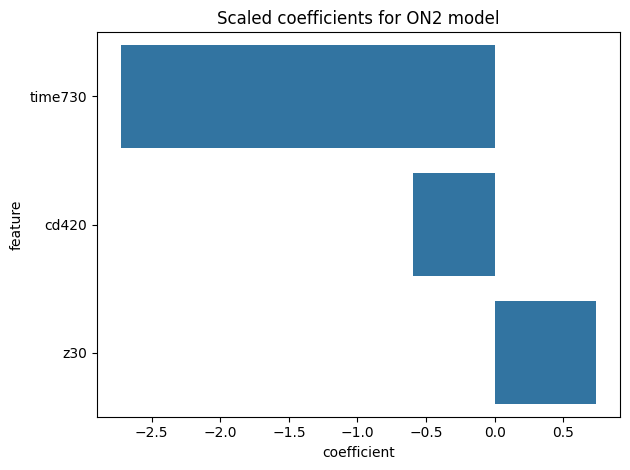

In [119]:
#fig, axes = plt.subplots(1,2, figsize = (8,3))

sns.barplot(data = coefficients, y = "feature", x = "coefficient", ax = None)

plt.title("Scaled coefficients for ON2 model")

plt.tight_layout()
plt.show()

The previous chart emphasizes the feature importances and their contribution. More time and more cd4 count biases towards "not infected". Someone that has taken zidovudine previous to the study has bias towards "infected".

#### Obtain coefficients for the unscaled variables

The coefficients found in the previous section are relative to the features scaled with StandardScaler. They are therefore hard to interpret as they are. 
We now calculate the coefficients one gets for the un-scaled regressors. 

In [123]:
scaler = model3.scaler_on_

In [143]:
# for each variable we calculate the rate of scaling 
scaling_factors = pd.DataFrame({
    "feature": model3.features_on,
    "scaling_factor": model3.scaler_on_.scale_,
    "average" : scaler.inverse_transform([[0,0,0]])[0],
    "coefficients" : model.coef_[0]
})
scaling_factors['coefficient_unscaled'] = scaling_factors['coefficients']/scaling_factors['scaling_factor']
scaling_factors

,feature,scaling_factor,average,coefficients,coefficient_unscaled
0,z30,0.497018,0.554527,0.741065,1.491023
1,cd420,140.359609,408.644033,-0.596889,-0.004253
2,time730,105.734379,320.912551,-2.726078,-0.025782


Let's calculate the base score.

In [161]:
transformed_zeros = scaler.transform(pd.DataFrame({feat : [0] for feat in features}))[0]
print(transformed_zeros)
print(model.coef_[0])
print(model.coef_[0]* transformed_zeros)
print(model.intercept_[0])
print()
base_score = model.intercept_[0] + sum(model.coef_[0]* transformed_zeros)




[-1.11570771 -2.91140761 -3.0350824 ]
[ 0.74106528 -0.59688894 -2.72607757]
[-0.82681224  1.737787    8.27387007]
-2.0559628875399203



In [162]:
print("A patient with null features has a base total score of ")
print(base_score)
incremental_scores = scaling_factors['coefficient_unscaled']
print('z30 adds the score', incremental_scores[0])
print('+100 count of cd420 adds the score', incremental_scores[1]*100)
print('30 days of time 730 adds the score', incremental_scores[2]*30)
print("if the final score is > 0 then the patient is classified as infected")

A patient with null features has a base total score of 
7.128881935304737
z30 adds the score 1.4910231913012755
+100 count of cd420 adds the score -0.4252569127356164
30 days of time 730 adds the score -0.7734695975717656
if the final score is > 0 then the patient is classified as infected


Let us rescale the scores so that the base score is 0 and the 0 score is 100. 

In [165]:
def rebase_score(z):
    return -100*z/base_score


print("A patient with null features has a base total score of ")
print(0)
incremental_scores = scaling_factors['coefficient_unscaled']
print('z30 adds the score', rebase_score(incremental_scores[0]))
print('+100 count of cd420 adds the score', rebase_score(incremental_scores[1]*100))
print('30 days of time 730 adds the score', rebase_score(incremental_scores[2]*30))
print("if the final score is <100 then the patient is classified as infected")

A patient with null features has a base total score of 
0
z30 adds the score -20.915245964689117
+100 count of cd420 adds the score 5.965267998472443
30 days of time 730 adds the score 10.8498023195092
if the final score is <100 then the patient is classified as infected


### OFFTRT Model coefficients

In [168]:
model = model_off
features = list(model.feature_names_in_)
features

['age',
 'drugs',
 'hemo',
 'cd820',
 'preanti',
 'race',
 'cd420',
 'time730',
 'z30',
 'time_censored']

In [169]:
# model intercept:
model.intercept_[0]

np.float64(-0.7937829394568983)

The intercept is negative. It means that an average OFF patient is evaluated by the models with a bias. This bias is towards the "non-infected" class. 

In [170]:
# we calculate the model coefficients for each feature 

coefficients = pd.DataFrame({
    "feature": features,
    "coefficient": model.coef_[0]
})

coefficients.sort_values(by="coefficient", inplace=True)
coefficients


,feature,coefficient
7,time730,-1.887500
6,cd420,-1.052369
2,hemo,-0.436777
5,race,-0.409325
9,time_censored,-0.391324
1,drugs,-0.187272
4,preanti,0.106265
3,cd820,0.120662
8,z30,0.304699
0,age,0.452847


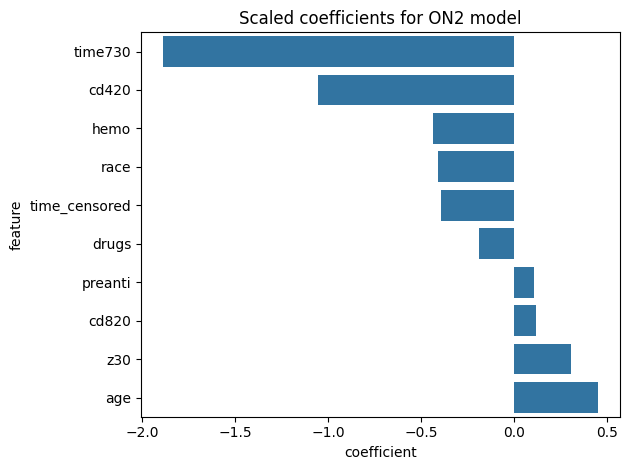

In [171]:
#fig, axes = plt.subplots(1,2, figsize = (8,3))

sns.barplot(data = coefficients, y = "feature", x = "coefficient", ax = None)

plt.title("Scaled coefficients for ON2 model")

plt.tight_layout()
plt.show()

The previous chart emphasizes the feature importances and their contribution. More time and more cd4 count biases towards "not infected". Someone that has taken zidovudine previous to the study has bias towards "infected".

#### Obtain coefficients for the unscaled variables

The coefficients found in the previous section are relative to the features scaled with StandardScaler. They are therefore hard to interpret as they are. 
We now calculate the coefficients one gets for the un-scaled regressors. 

In [174]:
scaler = model3.scaler_off_

In [194]:
# for each variable we calculate the rate of scaling 
scaling_factors = pd.DataFrame({
    "feature": model3.features_off,
    "scaling_factor": model3.scaler_off_.scale_,
    "coefficients" : model.coef_[0]
})
scaling_factors['coefficient_unscaled'] = scaling_factors['coefficients']/scaling_factors['scaling_factor']
scaling_factors

,feature,scaling_factor,coefficients,coefficient_unscaled
0,age,8.523222,0.452847,0.053131
1,drugs,0.358502,-0.187272,-0.522372
2,hemo,0.278421,-0.436777,-1.568765
3,cd820,428.540543,0.120662,0.000282
4,preanti,459.580908,0.106265,0.000231
5,race,0.451422,-0.409325,-0.906745
6,cd420,141.604681,-1.052369,-0.007432
7,time730,137.846009,-1.887500,-0.013693
8,z30,0.498339,0.304699,0.611428
9,time_censored,200.470965,-0.391324,-0.001952


Let's calculate the base score.

In [195]:
transformed_zeros = scaler.transform(pd.DataFrame({feat : [0] for feat in features}))[0]
print(transformed_zeros)
print(model.coef_[0])
print(model.coef_[0]* transformed_zeros)
print(model.intercept_[0])
print()
base_score = model.intercept_[0] + sum(model.coef_[0]* transformed_zeros)




[-4.0424146  -0.42249601 -0.304182   -2.15585895 -0.76136495 -0.6313741
 -2.388905   -0.89621085 -1.08503685 -0.78552807]
[ 0.45284729 -0.18727167 -0.43677662  0.12066241  0.10626511 -0.40932494
 -1.0523691  -1.88749978  0.30469887 -0.39132371]
[-1.8305965   0.07912153  0.13285959 -0.26013114 -0.08090653  0.25843716
  2.5140098   1.69159777 -0.3306095   0.30739576]
-0.7937829394568983



In [196]:
print("A patient with null features has a base total score of ")
print(base_score)
incremental_scores = scaling_factors['coefficient_unscaled'].copy()

for i,feat in enumerate(features) :
    print(f'{i} {feat} adds the score {round(incremental_scores[i],4)}')
print("if the final score is > 0 then the patient is classified as infected")

A patient with null features has a base total score of 
1.6873949991866168
0 age adds the score 0.0531
1 drugs adds the score -0.5224
2 hemo adds the score -1.5688
3 cd820 adds the score 0.0003
4 preanti adds the score 0.0002
5 race adds the score -0.9067
6 cd420 adds the score -0.0074
7 time730 adds the score -0.0137
8 z30 adds the score 0.6114
9 time_censored adds the score -0.002
if the final score is > 0 then the patient is classified as infected


Let us rescale the scores so that the base score is 0 and the 0 score is 100. 

In [198]:
def rebase_score(z):
    return -100*z/base_score

def multiplier_coefficient(feature):
    if feat in "time preanti time_censored time730".split():
        return 30
    elif feat in "cd80 cd820 cd40 cd420".split():
        return 100
    elif feat in "age wtkg karnof".split():
        return 10
    else:
        return 1

incremental_scores = scaling_factors['coefficient_unscaled'].copy()

print("A patient with null features has a base total score of ")
print(0)
for i,feat in enumerate(features) :
    score = incremental_scores[i] * multiplier_coefficient(feat)
    print(f'{i} {feat} adds the score {round(rebase_score(score),1)}')
print("if the final score is > 0 then the patient is classified as infected")

A patient with null features has a base total score of 
0
0 age adds the score -31.5
1 drugs adds the score 31.0
2 hemo adds the score 93.0
3 cd820 adds the score -1.7
4 preanti adds the score -0.4
5 race adds the score 53.7
6 cd420 adds the score 44.0
7 time730 adds the score 24.3
8 z30 adds the score -36.2
9 time_censored adds the score 3.5
if the final score is > 0 then the patient is classified as infected


## Other

In [189]:
# we merge with model coefficients 
coefficients_and_scaling_skb = coefficients_skb.merge(scaling_factors)
coefficients_and_scaling_rfe = coefficients_rfe.merge(scaling_factors)

# calculate un-scaled coefficient
coefficients_and_scaling_skb["coefficient_unscaled"] = coefficients_and_scaling_skb["coefficient"] / coefficients_and_scaling_skb["scaling_factor"]
coefficients_and_scaling_rfe["coefficient_unscaled"] = coefficients_and_scaling_rfe["coefficient"] / coefficients_and_scaling_rfe["scaling_factor"]

# order and print the results
coefficients_and_scaling_skb.sort_values(by="coefficient", ascending=False, inplace=True)
coefficients_and_scaling_rfe.sort_values(by="coefficient", ascending=False, inplace=True)

print("Feature coefficients of the model selected by SKB:")
print(coefficients_and_scaling_skb)
print()
print("Feature coefficients of the model selected by RFE:")
print(coefficients_and_scaling_skb)



NameError: name 'coefficients_skb' is not defined

### 049-b Model coefficients separately for binary vs continuous features

The log-odd contribution of our categorical variables is binary. The contribution of continuous features is proportional to their value. 
It is best to interpret the two types of variables separately. 

In [190]:
# we filter the categorical (binary) features 
binary_skb_mask = coefficients_and_scaling_skb['feature'].isin(cat_features)
binary_rfe_mask = coefficients_and_scaling_rfe['feature'].isin(cat_features)

coefficients_unscaled_skb_binary = coefficients_and_scaling_skb[binary_skb_mask].drop(columns = ["coefficient","scaling_factor"])
coefficients_unscaled_rfe_binary = coefficients_and_scaling_rfe[binary_rfe_mask].drop(columns = ["coefficient","scaling_factor"])

coefficients_unscaled_skb_continuous = coefficients_and_scaling_skb[~binary_skb_mask].drop(columns = ["coefficient","scaling_factor"])
coefficients_unscaled_rfe_continuous = coefficients_and_scaling_rfe[~binary_rfe_mask].drop(columns = ["coefficient","scaling_factor"])

# print for example
coefficients_unscaled_skb_binary


NameError: name 'coefficients_and_scaling_skb' is not defined

To better understand and compare the variables and coefficients we further custom-rescale the continuous variables.

In [191]:
# custom scale continuous features 

for coefficients_unscaled in [coefficients_unscaled_skb_continuous, coefficients_unscaled_rfe_continuous]:

    # - time730, time_censored : unit = month (scale 30)
    time_features_mask = coefficients_unscaled["feature"].isin(["time730","time_censored"])

    coefficients_unscaled.loc[time_features_mask, "feature"] += " (months)"
    coefficients_unscaled.loc[time_features_mask, "coefficient_unscaled"] *= 30

    # - cd40, cd420 : unit = hundreds (scale 100)
    lab_features_mask = coefficients_unscaled["feature"].isin(["cd40","cd420"])

    coefficients_unscaled.loc[lab_features_mask, "feature"] += " (x100)"
    coefficients_unscaled.loc[lab_features_mask, "coefficient_unscaled"] *= 100

print("Unscaled coefficients for SKB model")
print(coefficients_unscaled_skb_continuous)
print()
print("Unscaled coefficients for RFE model")
print(coefficients_unscaled_rfe_continuous)


NameError: name 'coefficients_unscaled_skb_continuous' is not defined

### 049-c Visualize coefficients of unscaled variables

NameError: name 'coefficients_unscaled_skb_binary' is not defined

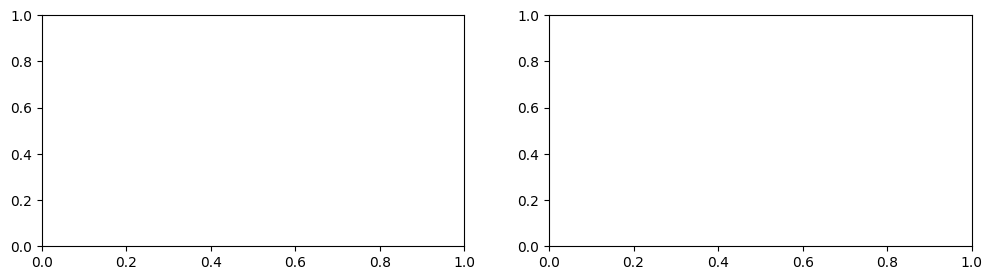

In [192]:
# Plot coefficients of binary features 
fig, axes = plt.subplots(1,2, figsize = (12,3))

sns.barplot(data = coefficients_unscaled_skb_binary, y = "feature", x = "coefficient_unscaled", ax = axes[0])
sns.barplot(data = coefficients_unscaled_rfe_binary, y = "feature", x = "coefficient_unscaled", ax = axes[1])

axes[0].set_title("Unscaled coefficients for best SKB model")
axes[1].set_title("Unscaled coefficients for best RFE model")

axes[0].set_ylabel("binary features")
axes[1].set_ylabel("binary features")
plt.tight_layout()
plt.show()

# Plot coefficients of continuous features
fig, axes = plt.subplots(1,2, figsize = (12,3))

sns.barplot(data = coefficients_unscaled_skb_continuous, y = "feature", x = "coefficient_unscaled", ax = axes[0])
sns.barplot(data = coefficients_unscaled_rfe_continuous, y = "feature", x = "coefficient_unscaled", ax = axes[1])

axes[0].set_title("Unscaled coefficients for best SKB model")
axes[1].set_title("Unscaled coefficients for best RFE model")

axes[0].set_ylabel("continuous features")
axes[1].set_ylabel("continous features")

plt.tight_layout()
plt.show()

## 050 + 052 Test set performance 

### Test performance with RFE

In [ ]:
y_pred_rfe = model_rfe.predict(X_rfe_test)

In [ ]:
results_test_rfe = {
    "accuracy": accuracy_score(y_test,y_pred_rfe),
    "recall": recall_score(y_test,y_pred_rfe),
    "selectivity": recall_score(y_test,y_pred_rfe,pos_label = 0),
    "precision": precision_score(y_test,y_pred_rfe),
    "NPV": precision_score(y_test,y_pred_rfe, pos_label = 0),
    "f1": f1_score(y_test,y_pred_rfe),
    "f3": fbeta_score(y_test,y_pred_rfe,beta = 3)
}

results_test_rfe

{'accuracy': 0.8948598130841121,
 'recall': np.float64(0.8076923076923077),
 'selectivity': np.float64(0.9228395061728395),
 'precision': np.float64(0.7706422018348624),
 'NPV': np.float64(0.9373040752351097),
 'f1': np.float64(0.7887323943661971),
 'f3': np.float64(0.8038277511961722)}

The recall score has dropped. The reason is clear: in cross-validation we used over-sampling. It would be better to oversample as part of the model. 

### Test performance with SKB

In [193]:
y_pred_skb = model_skb.predict(X_skb_test)

NameError: name 'model_skb' is not defined

In [194]:
results_test_skb = {
    "accuracy": accuracy_score(y_test,y_pred_skb),
    "recall": recall_score(y_test,y_pred_skb),
    "selectivity": recall_score(y_test,y_pred_skb,pos_label = 0),
    "precision": precision_score(y_test,y_pred_skb),
    "NPV": precision_score(y_test,y_pred_skb, pos_label = 0),
    "f1": f1_score(y_test,y_pred_skb),
    "f3": fbeta_score(y_test,y_pred_rfe,beta = 3)

}

results_test_skb

NameError: name 'y_pred_skb' is not defined

Interestingly, the recall is higher than the selectivity with this model. It would be interesting to know which features do help to increase the recall score.


In [195]:
print(rfe_selected_features)
print(skb_selected_features)

['hemo', 'gender', 'time730', 'offtrt', 'time_censored', 'race', 'z30', 'cd420', 'drugs']
['race', 'time_censored', 'time730', 'cd420', 'offtrt']


## 051 Confusion matrix 


In [196]:
cm_rfe  = confusion_matrix(y_test,y_pred_rfe)
cm_skb  = confusion_matrix(y_test,y_pred_skb)

NameError: name 'y_pred_rfe' is not defined

NameError: name 'cm_skb' is not defined

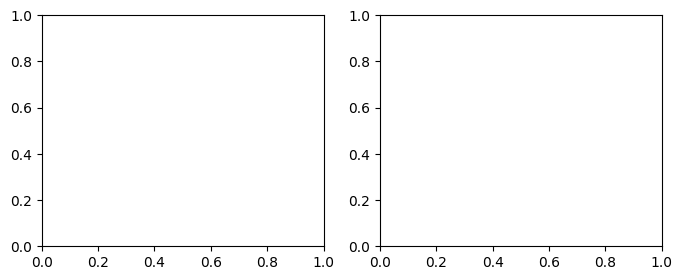

In [197]:
fig,ax = plt.subplots(1,2,figsize = (8,3))

sns.heatmap(cm_skb, annot=True, fmt='d', cmap='Blues', cbar=False, ax = ax[0])
sns.heatmap(cm_rfe, annot=True, fmt='d', cmap='Blues', cbar=False, ax = ax[1])

ax[0].set_title("Confusion matrix of SKB model")
ax[1].set_title("Confusion matrix of RFE model")
for i in [0,1]:
    ax[i].set_xlabel("Predicted Labels")
    ax[i].set_ylabel("True Labels")

plt.show()

In [ ]:
cm_rfe [0]

array([299,  25])

In [ ]:

num_test = [int(sum(cm_rfe[0])),int(sum(cm_rfe[1]))]
num_test

[324, 104]

## 053 Visualize confusion matrix data

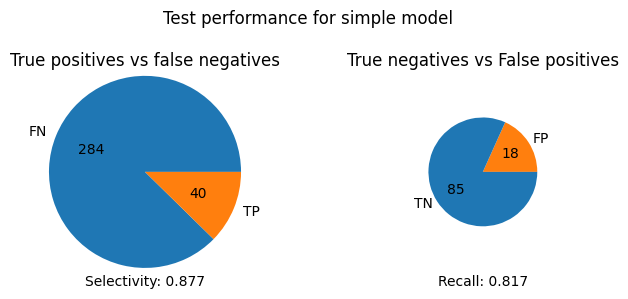

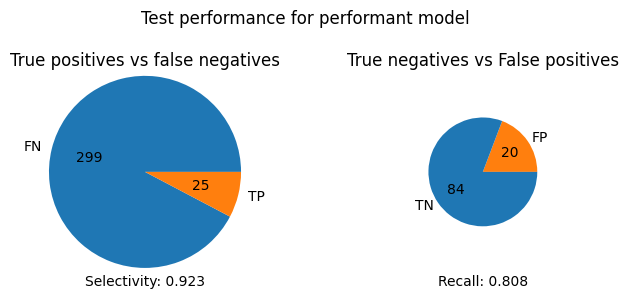

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (7,3))

# true infected vs true not infected test data count
num_test = [int(sum(cm_skb[0])),int(sum(cm_skb[1]))]


ax[0].set_title("True positives vs false negatives")
ax[1].set_title("True negatives vs False positives")
labels_pie = [["FN", "TP"],["FP", "TN"]]

for i in [0,1]:
    ax[i].pie(cm_skb[i], 
        labels = labels_pie[i], 
        colors = [sns.color_palette()[i], sns.color_palette()[1-i]], 
        radius = np.sqrt(2*num_test[i] / (num_test[0] + num_test[1])),
        autopct= lambda p: f'{int(num_test[i] * p / 100 )}') # to compute the count instead of the percentage
    
ax[0].set_xlabel(f"Selectivity: {results_test_skb["selectivity"]:.3f}")
ax[1].set_xlabel(f"Recall: {results_test_skb["recall"]:.3f}")
fig.suptitle("Test performance for simple model")
plt.tight_layout()
plt.show()


fig,ax = plt.subplots(1,2,figsize = (7,3))

# true infected vs true not infected test data count
num_test = [int(sum(cm_rfe[0])),int(sum(cm_rfe[1]))]


ax[0].set_title("True positives vs false negatives")
ax[1].set_title("True negatives vs False positives")
labels_pie = [["FN", "TP"],["FP", "TN"]]

for i in [0,1]:
    ax[i].pie(cm_rfe[i], 
        labels = labels_pie[i], 
        colors = [sns.color_palette()[i], sns.color_palette()[1-i]], 
        radius = np.sqrt(2*num_test[i] / (num_test[0] + num_test[1])),
        autopct= lambda p: f'{int(num_test[i] * p / 100 )}') # to compute the count instead of the percentage
    
ax[0].set_xlabel(f"Selectivity: {results_test_rfe["selectivity"]:.3f}")
ax[1].set_xlabel(f"Recall: {results_test_rfe["recall"]:.3f}")
fig.suptitle("Test performance for performant model")


plt.tight_layout()
plt.show()



## Save Logistic Regression Model

In [198]:
import pickle

In [ ]:
# Save model to file
model = model_rfe
filename = "models/logistic_RFE9.pkl"
file = open(filename, "wb")
#pickle.dump(model, file)

# The wb indicates that the file is opened for writing in binary mode.




We also save to file the features

In [ ]:
#pickle.dump(results_rfe_kfold_cv['features'], open("models/rfe_features_250103.pkl", "wb"))